## Mathematical aspects of Machine Learning: exercise sheet 9

Lecturers: Péter Koltai, Mattes Mollenhauer

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# this module requires installation of 'qpsolvers' and 'osqp'
# if you use pip, you can run
# $pip install qpsolvers
# $pip install osqp
from qpsolvers import solve_qp

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
np.random.seed(1234)

We generate data from the distribution given on Sheet 5.

In [ ]:
def generate_data(l, plot=True, exercise_1g=False):
    '''
    returns (2,l)-shaped float data array X and {+/-1} Y label vector
    corresponding to distributions given in the exercise
    '''
    Y = []
    X = np.random.uniform(low=-1.0,high=1.0,size=(l,2))
    #generate Y
    for x in X:
        decision_variable=np.random.uniform(low=0,high=1.0)
        if exercise_1g:
            threshold = 1/4 * (x[0] + 1) * (x[1] + 1)
        else:
            threshold = (x[0]+1)/2.0
        if decision_variable <= threshold:
            Y.append(1)
        else:
            Y.append(-1)
    if plot:
        plt.scatter(X[:,0],X[:,1],c=Y,cmap='viridis')
        plt.show()
    
    return X, np.array(Y)

We solve the QP 
$$
\max_{\alpha \in R^n} 
\sum_{i=1}^n \alpha_i - \sum_{i=1}^n \sum_{j=1}^n y_i y_j \alpha_i \alpha_j
\langle x_i, x_j \rangle
$$
subject to the constraints
$$
0 \leq \alpha_i \leq 2(n\lambda)^{-1}
$$
for some $\lambda > 0$
and obtain weights for the (linear) SVM
by
$$
w = \sum_{i=1}^n \alpha_i y_i x_i \in R^n.
$$

In [ ]:
def svm_hom_lin(X, Y, reg):
    """
    Returns coefficient vector obtained from the (homogeneous) SVM
    algorithm by solving the associated QP.
    """
    X_tilde = X * Y[:, np.newaxis]
    M = X_tilde @ X_tilde.T
    
    q = - 1 * np.ones(n_samples).reshape((n_samples,))
    lb = np.zeros(n_samples).reshape((n_samples,))
    ub = np.ones(n_samples).reshape((n_samples,)) * 2 / (n_samples * reg)
    alpha = solve_qp(M, q, solver="osqp", lb=lb, ub=ub)
    return alpha

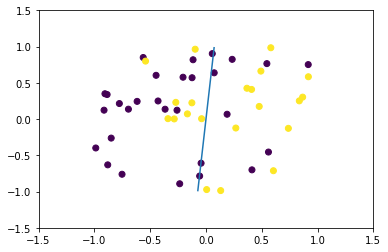

In [ ]:
n_samples = 50

X, Y = generate_data(n_samples, plot=False)

alpha = svm_hom_lin(X ,Y, .3)
w = np.array( sum([ alpha[i] * Y[i] * X[i,:] for i in range(n_samples)]) )

from sympy import symbols
from sympy.solvers.solveset import linsolve
from sympy import plot,solve

x, y = symbols('x, y')
solution = solve([w[0] * x + w[1] * y], (x, y))
solfunc = solution[x]
eval_vec = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 10)
solutions = [solfunc.subs(y,i) for i in eval_vec]
plt.plot(solutions, eval_vec)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis')
plt.gca().set_xlim((-1.5, 1.5))
plt.gca().set_ylim((-1.5, 1.5))
plt.title('')
plt.show()  

For simplicity, we wrap the function from above into a class that can work with generic kernels.

In [ ]:
class SVM_hom:

    def __init__(self, kernel):
        self.kernel = kernel
        self.alpha = None
        
    def fit(self, X, Y, reg):
        self.X = X
        self.Y = Y
        n_samples = X.shape[0]
        K = self.kernel(X, X)
        Y_tilde = np.diag(Y)
        K_tilde = Y_tilde @ K @ Y_tilde

        q = - 1 * np.ones(n_samples).reshape((n_samples,))
        lb = np.zeros(n_samples).reshape((n_samples,))
        ub = np.ones(n_samples).reshape((n_samples,)) * 2 / (n_samples * reg)
        self.alpha = solve_qp(K_tilde, q, solver="osqp", lb=lb, ub=ub)
        
    def predict(self, X_test):
        if self.alpha is None:
            raise Exception("Fit model first before predicting")
        ev = np.diag(self.alpha) @ np.diag(self.Y) @ self.kernel(self.X, X_test)
        return np.sign(np.sum(ev, axis=0))
        

In [ ]:
from scipy.spatial.distance import cdist

def kernel_linear(X1, X2):
    """
    Pairwise evaluations of linear kernel.
    """
    return X1 @ X2.T

def kernel_rbf(X1, X2, bandwidth=.1):
    """
    Pairwise evaluations of Gaussian kernel.
    """
    return np.exp(- 1 * cdist(X1, X2, "sqeuclidean") / (2 * bandwidth**2))

We now compare the linear SVM to the Gaussian SVM.
We fit both models on differently sized datasets and use a test set to compute the empirical error. Note that the Bayes classifier in this
case is given by the sign of the first dimension of datapoints in $X$.

We sample a large number of test points, such that the resulting test error
should be close to the analytical generalization error.

Note that the Bayes error is $0.25$ - hence the generalization error of any model can not be lower than this value.

In [ ]:
reg = .3
n_test = 3000
X_test, Y_test = generate_data(n_test, plot=False)

n_samples = [5, 10, 20, 30, 40, 50, 100, 200, 300, 400]
train_err_lin = []
test_err_lin = []

train_err_rbf = []
test_err_rbf = []

for n in n_samples:
    X, Y = generate_data(n, plot=False)
    
    svm_lin = SVM_hom(kernel_linear)
    svm_lin.fit(X, Y, reg=reg)
    
    train_err_lin.append( np.sum( Y != svm_lin.predict(X)) / n )
    test_err_lin.append( np.sum( Y_test != svm_lin.predict(X_test)) / n_test)
    
    train_err_bayes = ( np.sum( Y != np.sign(X[:,0]) ) / n )
    test_err_bayes = ( np.sum( Y_test != np.sign(X_test[:,0]) ) / n )
    
    svm_rbf = SVM_hom(kernel=kernel_rbf)
    svm_rbf.fit(X, Y, reg=reg)
    
    train_err_rbf.append( np.sum( Y != svm_rbf.predict(X)) / n )
    test_err_rbf.append( np.sum( Y_test != svm_rbf.predict(X_test)) / n_test)
    

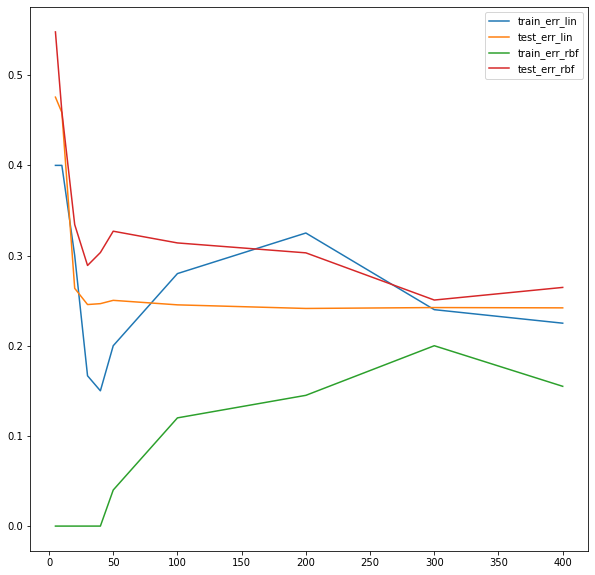

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(n_samples, train_err_lin, label="train_err_lin")
plt.plot(n_samples, test_err_lin, label="test_err_lin")

plt.plot(n_samples, train_err_rbf, label="train_err_rbf")
plt.plot(n_samples, test_err_rbf, label="test_err_rbf")

plt.plot()


plt.legend()